<a href="https://colab.research.google.com/github/yinon2592/DL_Project_046211/blob/main/section_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
# links : https://colab.research.google.com/drive/13dZVYEOMhXhkXWfvSMVM1TTtUDrT6Aeh

In [200]:
from google.colab import drive
# drive.mount('/content/drive/my-drive/project_calculations')
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [201]:
!pip install transformers
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk

In [202]:
### Prepare data
import os
import pandas as pd
from torch.utils.data import Dataset
import re
import torch
# Step 1: Dataset Preparation
# Step 2: Data Preprocessing

# load section_c data (data already cleaned)
section_c_data_path = '/content/drive/My Drive/project_dataset/section_c_data.csv'
df = pd.read_csv(section_c_data_path)
df.dropna(how='any', inplace=True)
df = df.head(500_000) # !!! to update df num of samples if needed !!!
print("dataset size is ", df.shape[0])
print(df.label.value_counts())
print(df.sample(5), "\n")

dataset size is  100
0    54
1    46
Name: label, dtype: int64
    label                                               text
83      0                               dam texts woke me up
53      0  printin stuff for my aunt dont ask y its so la...
70      0                  girls i am outta it then my exams
45      0                            i was caller number one
44      1  ha that sounds so wrong stacy lmao i love you ... 



In [203]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [204]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [205]:
batch_size = 2

In [206]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, labels, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt, sentiment in zip(txt_list, labels):

      encodings_dict = tokenizer('<|startoftext|>'+ txt + f". among positive and negative, the previous text was {sentiment}. " + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

In [207]:
bios = df.text.copy() #just use the main bio text in this example
bios

# dataset = GPT2Dataset(bios, tokenizer, max_length=768)
# print(len(dataset))
# train_size = int(len(dataset) * 0.8)  # 80% for training
# print("train_size is ", train_size)
# val_size = len(dataset) - train_size  # remaining for validation
# print("val_size is ", val_size)

# train_dataset = dataset[:train_size]  # First train_size rows for training
# val_dataset = dataset[train_size:train_size+val_size]  # Remaining val_size rows for validation


from sklearn.model_selection import train_test_split

dataset = GPT2Dataset(bios, df.label.copy(), tokenizer, max_length=768)

# Split into training and validation sets
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)

train_size = len(train_dataset)
val_size = len(val_dataset)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

   80 training samples
   20 validation samples


In [208]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [209]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [210]:
# some parameters I cooked up that work reasonably well

epochs = 5  # !!! to update df num of epochs if needed !!!
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [211]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [212]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [213]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [214]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

best_val_loss = float('inf')

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      print(" current best val_acc is ", best_val_loss)
      torch.save(model.state_dict(), '/content/drive/My Drive/project_calculations/section_c_generative_model.pth')

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...

  Average training loss: 1.80
  Training epoch took: 0:00:08

Running Validation...
 current best val_acc is  0.2136797398328781
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 2 / 5 ========
Training...

  Average training loss: 0.20
  Training epoch took: 0:00:07

Running Validation...
 current best val_acc is  0.15257910564541816
  Validation Loss: 0.15
  Validation took: 0:00:06

======== Epoch 3 / 5 ========
Training...

  Average training loss: 0.12
  Training epoch took: 0:00:10

Running Validation...
 current best val_acc is  0.12285970821976662
  Validation Loss: 0.12
  Validation took: 0:00:07

======== Epoch 4 / 5 ========
Training...

  Average training loss: 0.09
  Training epoch took: 0:00:10

Running Validation...
 current best val_acc is  0.11905083060264587
  Validation Loss: 0.12
  Validation took: 0:00:05

======== Epoch 5 / 5 ========
Training...

  Average training loss: 0.08
  Training epoch took: 0:00

In [215]:
# # Display floats with two decimal places.
# pd.set_option('precision', 2)

# Set the precision option
pd.set_option('display.float_format', '{:.2f}'.format)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.80,0.21,0:00:08,0:00:05
2,0.20,0.15,0:00:07,0:00:06
3,0.12,0.12,0:00:10,0:00:07
4,0.09,0.12,0:00:10,0:00:05
5,0.08,0.12,0:00:08,0:00:01


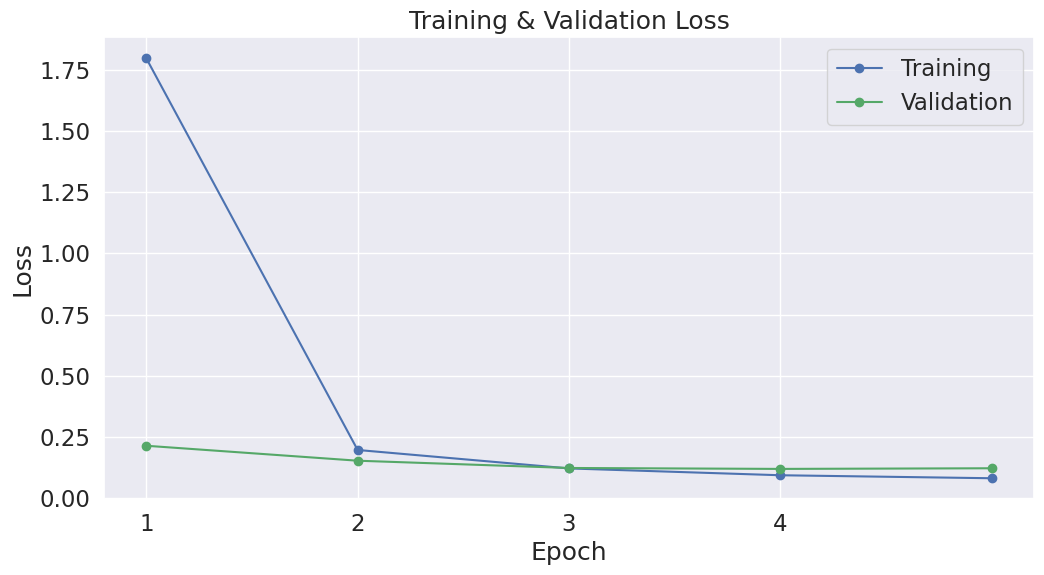

In [216]:
pd.DataFrame.from_dict(df_stats).to_csv('/content/drive/My Drive/project_calculations/section_c_all_loss.csv', index=False)

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [217]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [218]:
#  Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

# output_dir = '/content/drive/My Drive/project_calculations/section_c_model.pth'

# # Create output directory if needed
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

# print("Saving model to %s" % output_dir)

# # Save a trained model, configuration and tokenizer using `save_pretrained()`.
# # They can then be reloaded using `from_pretrained()`
# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))